# README

This notebook is a part of the reproducibility repository for the paper "Cohort-level analysis of human de novo mutations points to drivers of clonal expansion in spermatogonia." The notebook contains processing of The Human Protein Atlas single-cell data and the code generating some of the auxiliary plots for the paper as well as statistical tests for differential expression. The plots include:

1. Barplots of CES candidate gene expression in spermatogonia (average nTPM and relative nTPM).
2. Barplots of CES candidate gene expression in oogonia (average nTPM and relative nTPM).
3. Heatmap of CES candidate gene expression in fetal DAG clusters (percentage of cells expressing each gene).

# Dependencies

The following Python libraries are required for this notebook:

- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical computations.
- `matplotlib.pyplot`: For creating plots and visualizations.
- `seaborn`: For statistical data visualization.
- `gzip`: For handling compressed files.
- `scipy.stats`: For statistical tests like Mann-Whitney U.
- `re`: For regular expression operations.


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from scipy.stats import mannwhitneyu
import re


In [46]:
### Required files ###
# The list of files presented here is available online along with the code

# Table containing Gene IDs and their corresponding ENSEMBL IDs
ENS2Gene_file = "ENS_ID2Gene_ID.txt.gz"

# CHIP blacklist: list of genes involved in clonal hematopoiesis from Bernstein et al., 2024
blacklist_file = 'CHIP_blacklist.txt'

# CES gene list from Neville et al., 2024
NevilleCES_file = "Neville2024_list.txt"

# The Protein Atlas single-cell TPM expression data
TPA_sc_file = "rna_single_cell_cluster.tsv"

# List of all processed genes
processed_genes_file = "processed_genes.txt"

# Table with fetal expression from Xu et al., 2023 (supplementary Table 5 of the paper)
fetal_sc_file = "Supplementary Table 5.csv"

# Additional files for fetal expression
addfile1 = "tmp2.txt"
addfile2 = "tmp2.txt_annot_counts.pkl"



In [47]:
# Generate lists of genes used throughout the analysis

# Create a dictionary mapping ENSEMBL IDs to Gene IDs
df_ens2gene = pd.read_csv(gzip.open(ENS2Gene_file, 'rt'), sep='\t', header=None)
ENS2GeneID_dict = {row[0]: row[1] for row in df_ens2gene.values}

# Create a list of blacklisted genes involved in clonal hematopoiesis
# Read the blacklist file and extract the ENSEMBL IDs
# The blacklist file contains a single column with the header "ENS_ID"
CHIP_genes = np.array(list(pd.read_table(blacklist_file)["ENS_ID"]))

# Lists of CES genes stratified by sets
CE_LoF_ENS_1 = [
    'ENSG00000176165', 'ENSG00000157540', 'ENSG00000168036', 
    'ENSG00000185129', 'ENSG00000049618'
]

CE_LoF_ENS_2 = [
    'ENSG00000064419', 'ENSG00000101752', 'ENSG00000111262', 
    'ENSG00000115758', 'ENSG00000117139', 'ENSG00000119772', 
    'ENSG00000134440', 'ENSG00000136158', 'ENSG00000137834', 
    'ENSG00000141376', 'ENSG00000145907', 'ENSG00000146830', 
    'ENSG00000148737', 'ENSG00000157933', 'ENSG00000170836', 
    'ENSG00000171456', 'ENSG00000171862', 'ENSG00000196712', 
    'ENSG00000256463'
]

CE_GoF_ENS = [
    'ENSG00000068078', 'ENSG00000108061', 'ENSG00000112640', 
    'ENSG00000087191', 'ENSG00000273079', 'ENSG00000213639', 
    'ENSG00000179295', 'ENSG00000157764', 'ENSG00000101266', 
    'ENSG00000113163', 'ENSG00000141646', 'ENSG00000078369', 
    'ENSG00000065883', 'ENSG00000169032', 'ENSG00000198793', 
    'ENSG00000175115', 'ENSG00000179364', 'ENSG00000159692'
]

# Combine all sets of CES genes into a single array
all_CE = np.array(list(CE_LoF_ENS_1) +
                  list(CE_LoF_ENS_2) +
                  list(CE_GoF_ENS))

# Read the single-cell TPM expression data
sc_df = pd.read_table(TPA_sc_file)

# Combine all sets of recovered CES genes
all_sets_ENS = np.array(list(CE_LoF_ENS_1) +
                        list(CE_LoF_ENS_2) +
                        list(CE_GoF_ENS))

# Remove CHIP genes from the list of all CES genes
all_sets_ENS = all_sets_ENS[~np.isin(all_sets_ENS, CHIP_genes)]

# The list of all process coding autosomal gene ENSEMBL IDs
processed_gene_ENS = np.array(list(pd.read_table(processed_genes_file)["ensembl_gene_id"]))
# 

In [11]:
# Generate the vector of relative nTPMs: for each gene-tissue pair, it will measure the expression of a gene in the tissue relative to the maximal expression of that gene

# Init a dictionary to store the maximum expression (nTPM) for each gene
max_expr_dict = {}
for i in range(len(sc_df)):
    gene = sc_df["Gene"][i]
    nTPM = sc_df["nTPM"][i]
    
    # Init the maximum expression val for the gene if not already present
    if gene not in max_expr_dict:
        max_expr_dict[gene] = -1
    
    # Update the maximum expression if the current nTPM is greater
    if nTPM > max_expr_dict[gene]:
        max_expr_dict[gene] = nTPM

# Init a vector of relative expressions (rel_nTPM)
rel_expr_vec = []
for i in range(len(sc_df)):
    gene = sc_df["Gene"][i]
    nTPM = sc_df["nTPM"][i]
    
    # Calculate relative expression as nTPM divided by the maximum expression
    # If the maximum expression is non-positive, append NaN
    if max_expr_dict[gene] <= 0:
        rel_expr_vec.append(np.nan)
    else:
        rel_expr_vec.append(nTPM / max_expr_dict[gene])

# Add the relative expression vector as a new column in the dataframe
sc_df["rel_nTPM"] = rel_expr_vec

# 1. Expression barplots

This section visualizes the expression levels of CES candidate genes in spermatogonia and in oogonia. For each tissue, two barplots are generated: one for the average expression (nTPM) and one for the average relative expression defined as nTPM relative to the tissue where the gene is most expressed.

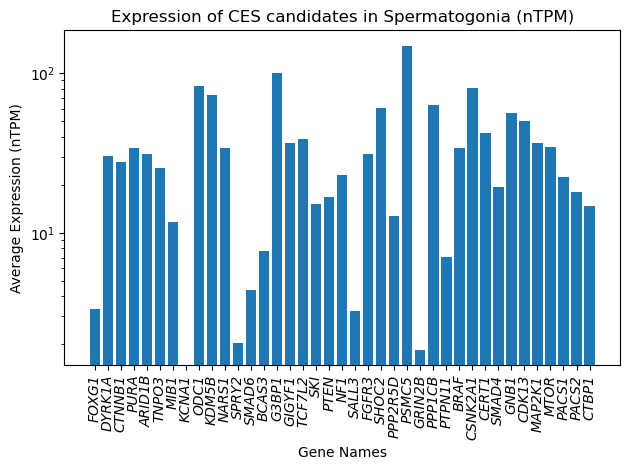

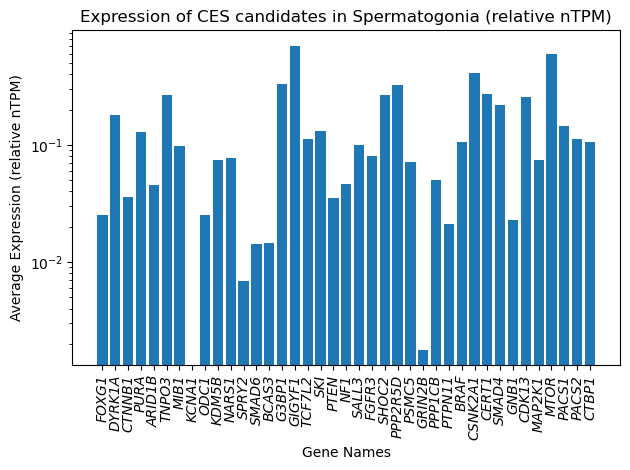

In [14]:
# First, spermatogonia

# Filter the dataframe for "spermatogonia" cell type
sc_df_SPG = sc_df[sc_df["Cell type"] == "spermatogonia"]

# Generate gene names for CES candidates using the ENS2GeneID dictionary
gene_names = [ENS2GeneID_dict[gene] for gene in all_sets_ENS if gene in ENS2GeneID_dict]

# Calculate average expression (nTPM) for each CES candidate in spermatogonia
avg_expression = [
    np.mean(sc_df_SPG[sc_df_SPG["Gene"] == gene]["nTPM"]) 
    for gene in all_sets_ENS
]

# Plot the bar chart for average expression (nTPM)
plt.bar(gene_names, avg_expression)
plt.xticks(rotation=90, fontstyle='italic', fontfamily='sans-serif')
plt.xlabel("Gene Names")
plt.ylabel("Average Expression (nTPM)")
plt.title("Expression of CES candidates in Spermatogonia (nTPM)")
plt.yscale("log")  # Use logarithmic scale for better visualization
plt.tight_layout() 
plt.savefig("CES_genes_SPG_nTPM.pdf")  # Save the plot as a PDF
plt.show()

# Calculate average relative expression (rel_nTPM) for each CES candidate in spermatogonia
avg_rel_expression = [
    np.mean(sc_df_SPG[sc_df_SPG["Gene"] == gene]["rel_nTPM"]) 
    for gene in all_sets_ENS
]

# Plot the bar chart for average relative expression (rel_nTPM)
plt.bar(gene_names, avg_rel_expression)
plt.xticks(rotation=90, fontstyle='italic', fontfamily='sans-serif')
plt.xlabel("Gene Names")
plt.ylabel("Average Expression (relative nTPM)")
plt.title("Expression of CES candidates in Spermatogonia (relative nTPM)")
plt.yscale("log")  # Use logarithmic scale for better visualization
plt.tight_layout()  
plt.savefig("CES_genes_SPG_rel_nTPM.pdf")  # Save the plot as a PDF
plt.show()

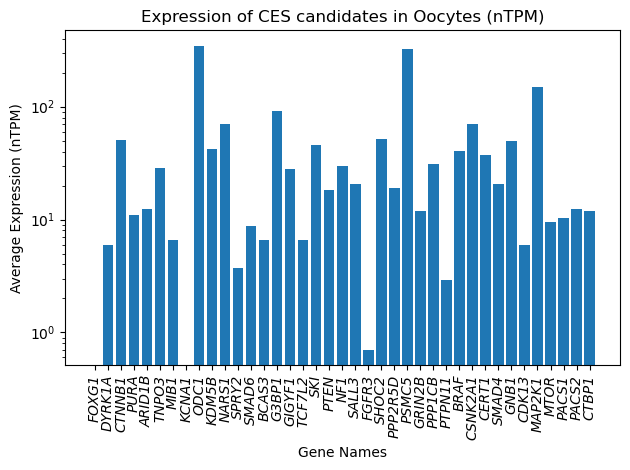

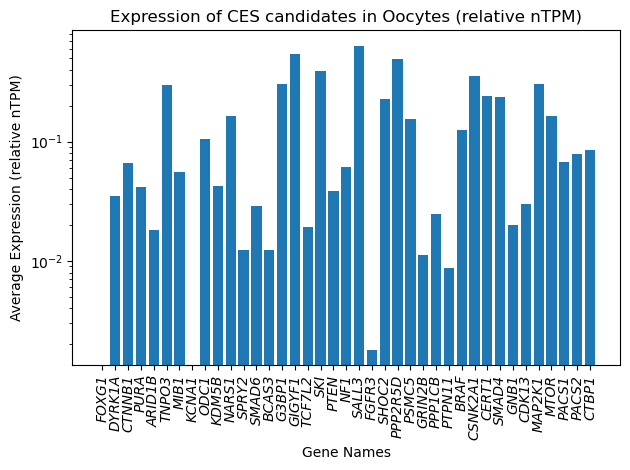

In [16]:
# Second, oogonia

sc_df_OOC = sc_df[sc_df["Cell type"] == "oocytes"]

# Generate gene names for CES candidates using the ENS2GeneID dictionary
gene_names = [ENS2GeneID_dict[gene] for gene in all_sets_ENS if gene in ENS2GeneID_dict]

# Calculate average expression (nTPM) for each CES candidate in oocytes
avg_expression = [
    np.mean(sc_df_OOC[sc_df_OOC["Gene"] == gene]["nTPM"]) 
    for gene in all_sets_ENS
]

# Plot the bar chart for average expression (nTPM)
plt.bar(gene_names, avg_expression)
plt.xticks(rotation=90, fontstyle='italic', fontfamily='sans-serif')
plt.xlabel("Gene Names")
plt.ylabel("Average Expression (nTPM)")
plt.title("Expression of CES candidates in Oocytes (nTPM)")
plt.yscale("log")  
plt.tight_layout() 
plt.savefig("CES_genes_OOC_nTPM.pdf")  # Save the plot as a PDF
plt.show()

# Calculate average relative expression for each CES candidate in oocytes
avg_rel_expression = [
    np.mean(sc_df_OOC[sc_df_OOC["Gene"] == gene]["rel_nTPM"]) 
    for gene in all_sets_ENS
]
# Plot the bar chart for average relative expression 
plt.bar(gene_names, avg_rel_expression)
plt.xticks(rotation=90, fontstyle='italic', fontfamily='sans-serif')
plt.xlabel("Gene Names")
plt.ylabel("Average Expression (relative nTPM)")
plt.title("Expression of CES candidates in Oocytes (relative nTPM)")
plt.yscale("log")  
plt.tight_layout()  
plt.savefig("CES_genes_OOC_rel_nTPM.pdf")  
plt.show()

# 2. Significance of differences in expression

Here, we test for significance of higher expression of the identified CES drivers in spermatogonia using the Mann-Whitney U test

In [25]:
def perform_mannwhitneyu_test(CES_genes, sc_df_SPG, processed_gene_ENS):
    """
    Perform Mann-Whitney U test for CES genes against all processed genes.

    CES_genes: List of CES genes.
    sc_df_SPG: Filtered dataframe for spermatogonia cell type.
    processed_gene_ENS: Array of all processed gene ENSEMBL IDs.
    """
    # Filter nTPMs for CES genes
    nTPM_CES = np.array(list(sc_df_SPG[sc_df_SPG["Gene"].isin(CES_genes)]["nTPM"]))
    rel_nTPM_CES = np.array(list(sc_df_SPG[sc_df_SPG["Gene"].isin(CES_genes)]["rel_nTPM"]))
    rel_nTPM_CES = rel_nTPM_CES[~np.isnan(rel_nTPM_CES)]

    # Complement to the CES genes: all processed genes that are not in the CES sets
    processed_gene_ENS_C = processed_gene_ENS[~np.isin(processed_gene_ENS, CES_genes)]
    nTPM_processed_genes_C = np.array(list(sc_df_SPG[sc_df_SPG["Gene"].isin(processed_gene_ENS_C)]["nTPM"]))
    rel_nTPM_processed_genes_C = np.array(list(sc_df_SPG[sc_df_SPG["Gene"].isin(processed_gene_ENS_C)]["rel_nTPM"]))
    rel_nTPM_processed_genes_C = rel_nTPM_processed_genes_C[~np.isnan(rel_nTPM_processed_genes_C)]

    # Mann-Whitney U test between the two groups
    # Absolute nTPMs
    stat, p_value = mannwhitneyu(nTPM_CES, nTPM_processed_genes_C, alternative='greater')
    print(f"M-W test for CES genes vs. all processed genes: U-statistic = {stat}, p-value = {p_value}")

    # Relative nTPMs
    stat, p_value = mannwhitneyu(rel_nTPM_CES, rel_nTPM_processed_genes_C, alternative='greater')
    print(f"REL M-W test for CES genes vs. all processed genes: U-statistic = {stat}, p-value = {p_value}")

# all sets together
print("Mann-Whitney U test for all CES genes vs. all processed genes:")
perform_mannwhitneyu_test(all_sets_ENS, sc_df_SPG, processed_gene_ENS)

# each set separately
print("\nMann-Whitney U test for LoF-1 set vs. all processed genes:")
perform_mannwhitneyu_test(CE_LoF_ENS_1, sc_df_SPG, processed_gene_ENS)

print("\nMann-Whitney U test for LoF-2 set vs. all processed genes:")
perform_mannwhitneyu_test(CE_LoF_ENS_2, sc_df_SPG, processed_gene_ENS)

print("\nMann-Whitney U test for GoF set vs. all processed genes:")
perform_mannwhitneyu_test(CE_GoF_ENS, sc_df_SPG, processed_gene_ENS)

# Now all LoF sets together
print("\nMann-Whitney U test for all LoF CES genes vs. all processed genes:")
perform_mannwhitneyu_test(CE_LoF_ENS_1 + CE_LoF_ENS_2, sc_df_SPG, processed_gene_ENS)

Mann-Whitney U test for all CES genes vs. all processed genes:
M-W test for CES genes vs. all processed genes: U-statistic = 1994042.0, p-value = 4.069425079669137e-12
REL M-W test for CES genes vs. all processed genes: U-statistic = 1825144.0, p-value = 1.462132786090246e-07

Mann-Whitney U test for LoF-1 set vs. all processed genes:
M-W test for CES genes vs. all processed genes: U-statistic = 252518.5, p-value = 0.009694479507510761
REL M-W test for CES genes vs. all processed genes: U-statistic = 218789.5, p-value = 0.08862394691894387

Mann-Whitney U test for LoF-2 set vs. all processed genes:
M-W test for CES genes vs. all processed genes: U-statistic = 893492.5, p-value = 0.0002175406266684447
REL M-W test for CES genes vs. all processed genes: U-statistic = 811742.5, p-value = 0.010037469600257854

Mann-Whitney U test for GoF set vs. all processed genes:
M-W test for CES genes vs. all processed genes: U-statistic = 996922.0, p-value = 2.057379091974066e-09
REL M-W test for CES 

# 3. Expression of CES candidates in fetal tissues

Now, we plot a heatmap of nTPMs for the identified CES driver candidates for fetal expression clusters from Xu et al., 2023 ("A single-cell transcriptome atlas profiles early organogenesis in human embryos")

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_79720/775264208.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  normalized_df["ENS_ID"] = normalized_df["Ensembl gene ID"]


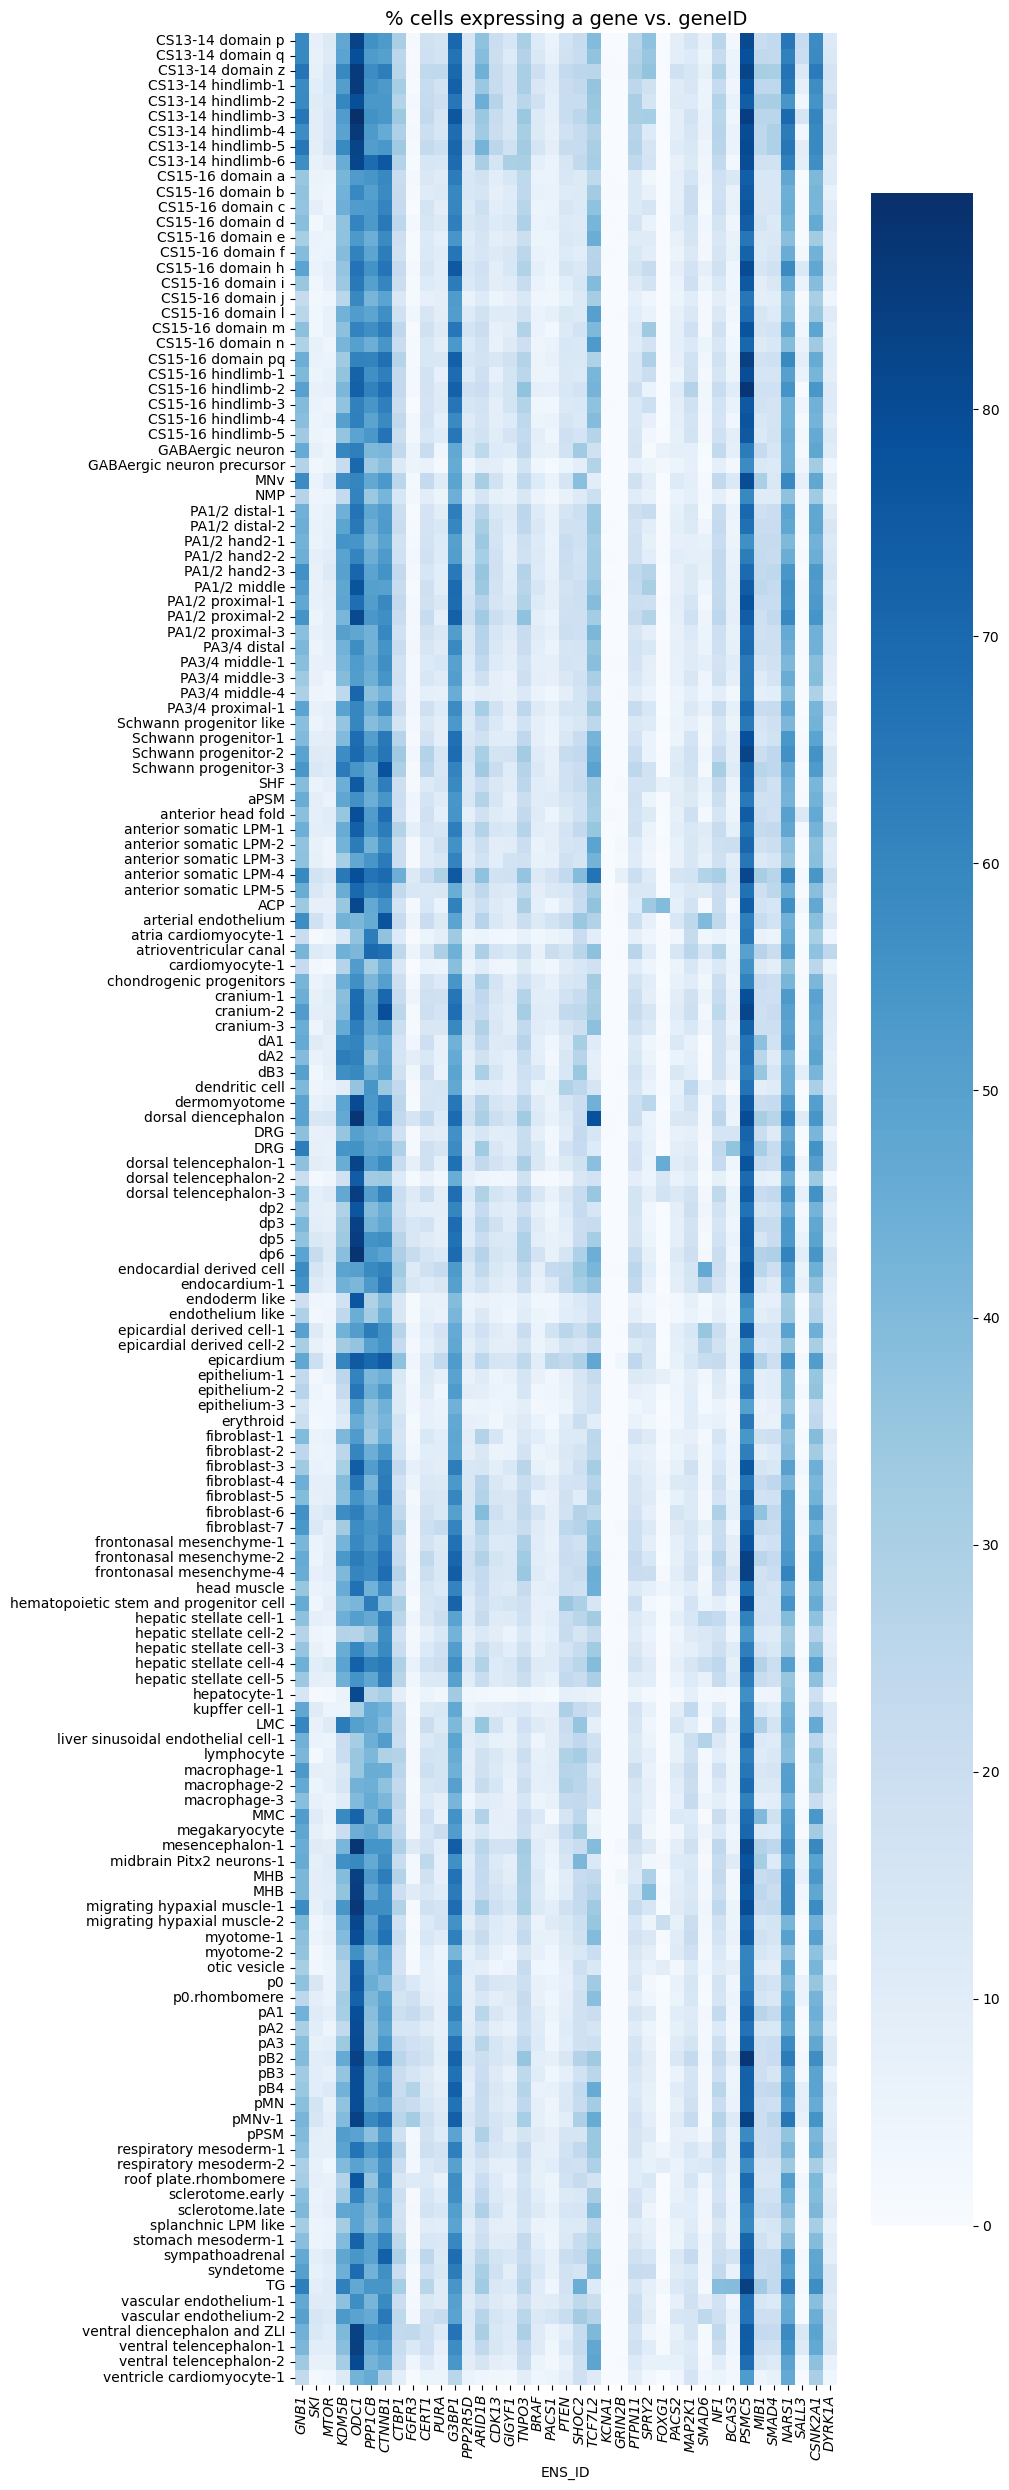

In [43]:
fetal_sc_file = "Supplementary Table 5.csv"
addfile1 = "tmp2.txt"
addfile2 = "tmp2.txt_annot_counts.pkl"

def normalize_expression_values(df, annot_counts_pkl):
    """
    Normalize the expression values in the DataFrame by the total number of cells in each cluster
    and filter columns where annotation counts are greater than 250.
    """
    # Load the annotation counts
    annot_counts = pd.read_pickle(annot_counts_pkl)

    # Filter columns where annotation counts are greater than 250 and exclude "undefined"
    valid_columns = [col for col in annot_counts.keys() if annot_counts[col] > 250 and "undefined" not in col]
    valid_columns = ["Ensembl gene ID"] + valid_columns  # Ensure "Ensembl gene ID" is included

    # Normalize the expression values by the total number of cells in each cluster
    normalized_df = df[valid_columns].copy()
    for col in valid_columns:
        if col in ["Ensembl gene ID", "ENS_ID"]:
            continue
        normalized_df[col] = normalized_df[col] * 100 / annot_counts[col]
    
    # Add a column for ENS_ID
    normalized_df["ENS_ID"] = normalized_df["Ensembl gene ID"]
    return normalized_df


def filter_genes_by_list(df, gene_list, rule_col="% of CLUSTER"):
    """
    Filter the DataFrame to include only rows corresponding to genes in the provided gene list.
    """
    filtered_df = df[df["Ensembl gene ID"].isin(gene_list)].reset_index(drop=True)

    # Create a dictionary for the filtered DataFrame
    filtered_data = {"ENS_ID": filtered_df["Ensembl gene ID"]}
    for col in filtered_df.columns:
        if rule_col in col:
            filtered_data[col] = filtered_df[col]
    
    return pd.DataFrame(filtered_data)


def merge_dataframes_by_gene_id(df1, df2, gene_id_mapping):
    """
    Merge two DataFrames by the ENS_ID column and update ENS_ID using a gene ID mapping dictionary.
    """
    merged_data = {**df1.to_dict(orient="list"), **df2.to_dict(orient="list")}
    merged_df = pd.DataFrame(merged_data)

    # Update ENS_ID using the gene ID mapping dictionary
    merged_df["ENS_ID"] = [gene_id_mapping.get(ens_id, ens_id) for ens_id in merged_df["ENS_ID"]]
    return merged_df


# Load the single-cell data
single_cell_df = pd.read_table(fetal_sc_file)

# Filter the single-cell data based on the gene list
filtered_sc_df = filter_genes_by_list(single_cell_df, all_sets_ENS)
filtered_sc_df = filtered_sc_df.sort_values(by="ENS_ID")

# Load the bulk data
bulk_data_df = pd.read_table(addfile1)
bulk_data_df.rename(columns={bulk_data_df.columns[0]: "Ensembl gene ID"}, inplace=True)

# Filter and normalize the bulk data
filtered_bulk_df = filter_genes_by_list(bulk_data_df, all_sets_ENS, rule_col="")
filtered_bulk_df = filtered_bulk_df.sort_values(by="ENS_ID")
normalized_bulk_df = normalize_expression_values(filtered_bulk_df, addfile2)

# Drop the "Ensembl gene ID" column from the normalized bulk data
normalized_bulk_df.drop(columns=["Ensembl gene ID"], inplace=True)

# Merge the single-cell and normalized bulk data
merged_df = merge_dataframes_by_gene_id(filtered_sc_df, normalized_bulk_df, ENS2GeneID_dict)

# Set the ENS_ID column as the index
merged_df.set_index("ENS_ID", inplace=True)

# Transpose the DataFrame for the heatmap
transposed_df = merged_df.T[17:]

# Extract column names within parentheses for y-axis tick labels
ytick_labels = [
    re.search(r'\((.*?)\)', str(col)).group(1) if '(' in str(col) and ')' in str(col) else str(col)
    for col in transposed_df.index
]

# Create the heatmap
plt.figure(figsize=(10, 25))
sns.heatmap(transposed_df, cmap="Blues", cbar=True)

# Customize the ticks and labels
plt.yticks(ticks=np.arange(len(ytick_labels)) + 0.5, labels=ytick_labels, rotation=0, horizontalalignment="right")
plt.xticks(rotation=90, fontfamily='sans-serif', fontstyle='italic')

# Customize the plot
plt.title("% cells expressing a gene vs. geneID", fontsize=14)
plt.tight_layout()

# Save and show the plot
plt.savefig("fetal_DAGs.pdf")
plt.show()
